In [1]:
import os
import sep
import numpy as np
import numba as nb
from glob import glob
from astropy.io import fits
from astropy.time import Time
from copy import deepcopy
from pathlib import Path
import datetime
import matplotlib.pyplot as plt
import os
import gc
import time as timer
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from matplotlib.colors import LogNorm

In [2]:
data_dir = "/home/agirmen/Github/ColibriPipeline_SensitivityModel/Sensitivity_Test_Data/20240729/20240729_02.29.34.690"

# Get the filepaths of all the files in the directory

filepaths = []
for root, dirs, files in os.walk(data_dir):
    files.sort()
    for file in files:
        if file.endswith(".rcd"):
            filepaths.append(os.path.join(root, file))
print(filepaths)

['/home/agirmen/Github/ColibriPipeline_SensitivityModel/Sensitivity_Test_Data/20240729/20240729_02.29.34.690/Alt89.2_25ms-_0000001.rcd', '/home/agirmen/Github/ColibriPipeline_SensitivityModel/Sensitivity_Test_Data/20240729/20240729_02.29.34.690/Alt89.2_25ms-_0000002.rcd', '/home/agirmen/Github/ColibriPipeline_SensitivityModel/Sensitivity_Test_Data/20240729/20240729_02.29.34.690/Alt89.2_25ms-_0000003.rcd', '/home/agirmen/Github/ColibriPipeline_SensitivityModel/Sensitivity_Test_Data/20240729/20240729_02.29.34.690/Alt89.2_25ms-_0000004.rcd', '/home/agirmen/Github/ColibriPipeline_SensitivityModel/Sensitivity_Test_Data/20240729/20240729_02.29.34.690/Alt89.2_25ms-_0000005.rcd', '/home/agirmen/Github/ColibriPipeline_SensitivityModel/Sensitivity_Test_Data/20240729/20240729_02.29.34.690/Alt89.2_25ms-_0000006.rcd', '/home/agirmen/Github/ColibriPipeline_SensitivityModel/Sensitivity_Test_Data/20240729/20240729_02.29.34.690/Alt89.2_25ms-_0000007.rcd', '/home/agirmen/Github/ColibriPipeline_Sensitivi

{'serialnum': b'KL1094218', 'timestamp': '2016-00-00T00:13:51.503504135'}


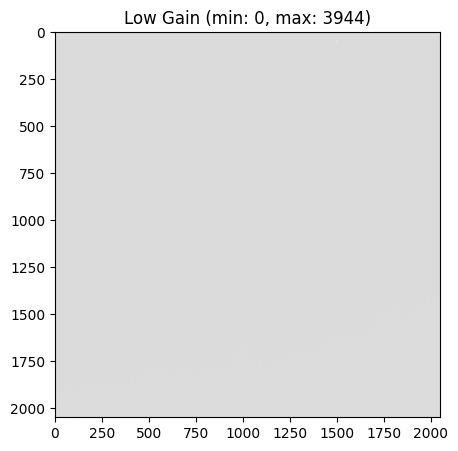

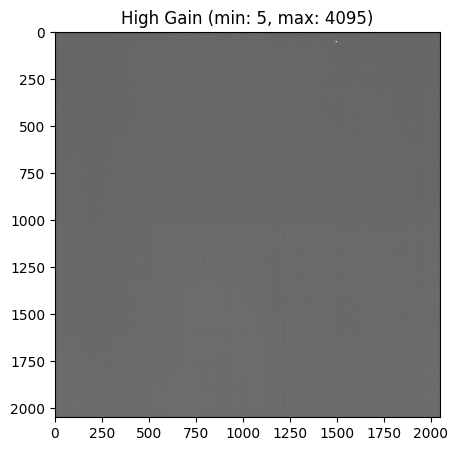

In [4]:
# Function for reading specified number of bytes
def readxbytes(fid, numbytes):
    for i in range(1):
        data = fid.read(numbytes)
        if not data:
            break
    return data

# Function to read 12-bit data with Numba to speed things up
@nb.njit(nb.uint16[::1](nb.uint8[::1]),fastmath=True,parallel=True)
def nb_read_data(data_chunk):
    """data_chunk is a contigous 1D array of uint8 data)
    eg.data_chunk = np.frombuffer(data_chunk, dtype=np.uint8)"""
    #ensure that the data_chunk has the right length

    assert np.mod(data_chunk.shape[0],3)==0

    out=np.empty(data_chunk.shape[0]//3*2,dtype=np.uint16)
    image1 = np.empty((2048,2048),dtype=np.uint16)
    image2 = np.empty((2048,2048),dtype=np.uint16)

    for i in nb.prange(data_chunk.shape[0]//3):
        fst_uint8=np.uint16(data_chunk[i*3])
        mid_uint8=np.uint16(data_chunk[i*3+1])
        lst_uint8=np.uint16(data_chunk[i*3+2])

        out[i*2] =   (fst_uint8 << 4) + (mid_uint8 >> 4)
        out[i*2+1] = ((mid_uint8 % 16) << 8) + lst_uint8

    return out

def getSizeRCD(filenames):
    """ MJM - Get the size of the images and number of frames """
    filename_first = filenames[0]
    frames = len(filenames)

    width = 2048
    height = 2048

    # You could also get this from the RCD header by uncommenting the following code
    # with open(filename_first, 'rb') as fid:
    #     fid.seek(81,0)
    #     hpixels = readxbytes(fid, 2) # Number of horizontal pixels
    #     fid.seek(83,0)
    #     vpixels = readxbytes(fid, 2) # Number of vertical pixels

    #     fid.seek(100,0)
    #     binning = readxbytes(fid, 1)

    #     bins = int(binascii.hexlify(binning),16)
    #     hpix = int(binascii.hexlify(hpixels),16)
    #     vpix = int(binascii.hexlify(vpixels),16)
    #     width = int(hpix / bins)
    #     height = int(vpix / bins)

    return width, height, frames

# Function to split high and low gain images
def split_images(data,pix_h,pix_v,gain):
    interimg = np.reshape(data, [2*pix_v,pix_h])

    if gain == 'low':
        image = interimg[::2]
    else:
        image = interimg[1::2]

    return image
 
# Function to read RCD file data
def readRCD(filename):

    hdict = {}

    with open(filename, 'rb') as fid:

        # Go to start of file
        fid.seek(0,0)

        # Serial number of camera
        fid.seek(63,0)
        hdict['serialnum'] = readxbytes(fid, 9)

        # Timestamp
        fid.seek(152,0)
        hdict['timestamp'] = readxbytes(fid, 29).decode('utf-8')

        # Load data portion of file
        fid.seek(384,0)

        table = np.fromfile(fid, dtype=np.uint8, count=12582912)

    return table, hdict


hnumpix = 2048
vnumpix = 2048



# file = "/home/agirmen/Github/ColibriPipeline_SensitivityModel/Sensitivity_Test_Data/other_rcd/pointing_reference_0000001.rcd"  # pointing ref loads fine
file = "/home/agirmen/Github/ColibriPipeline-Tonys-version/notebooks/Alt89.2_25ms-_0000001.rcd"

data, header = readRCD(file)
print(header)
images = nb_read_data(data)
low_gain = split_images(images, hnumpix, vnumpix, 'low')
high_gain = split_images(images, hnumpix, vnumpix, 'high')

# Plot the low and high gain side by side with colorbars and log scale
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cax0 = ax.imshow(low_gain, cmap='gray', norm=LogNorm(vmin=low_gain.min(), vmax=low_gain.max()))
ax.set_title(f'Low Gain (min: {low_gain.min()}, max: {low_gain.max()})')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cax0 = ax.imshow(high_gain, cmap='gray', norm=LogNorm(vmin=high_gain.min(), vmax=high_gain.max()))
ax.set_title(f'High Gain (min: {high_gain.min()}, max: {high_gain.max()})')
plt.show()

# save the high gain image as a fits file
hdu = fits.PrimaryHDU(high_gain)
hdu.writeto('high_gain_blue_25ms_testnew.fits', overwrite=False)

{'serialnum': b'KL1420719', 'timestamp': '2016-00-00T00:35:03.522074305'}


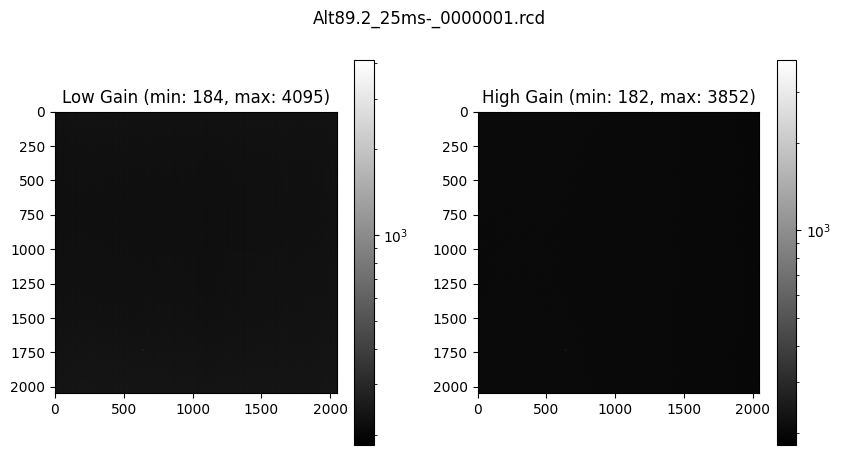

{'serialnum': b'KL1420719', 'timestamp': '2016-00-00T00:35:03.547089985'}


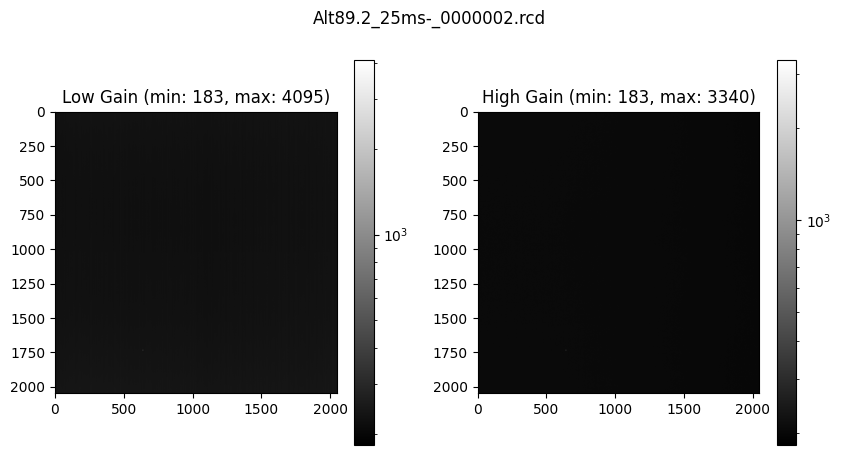

{'serialnum': b'KL1420719', 'timestamp': '2016-00-00T00:35:03.572105665'}


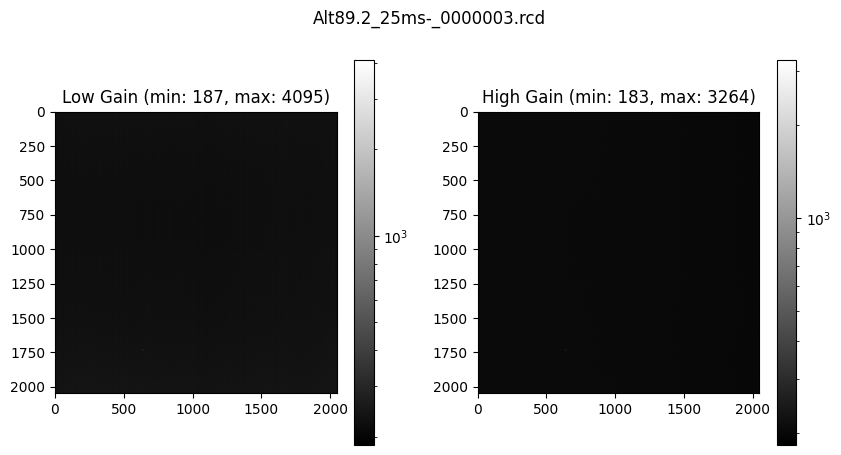

{'serialnum': b'KL1420719', 'timestamp': '2016-00-00T00:35:03.597121345'}


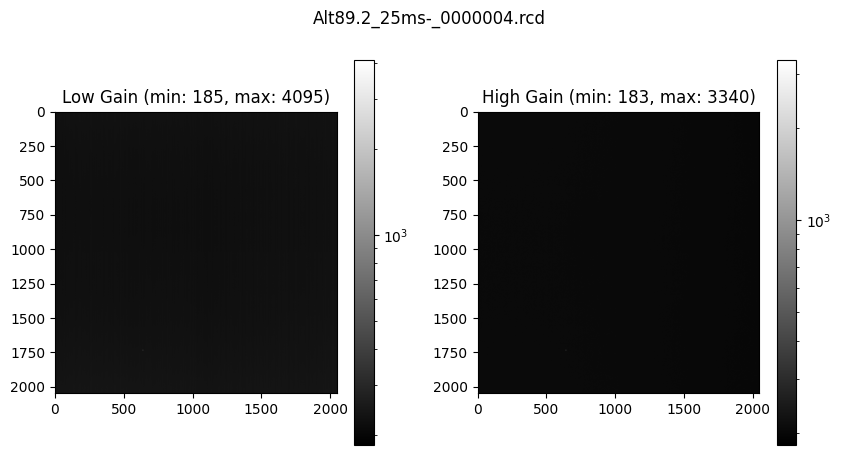

{'serialnum': b'KL1420719', 'timestamp': '2016-00-00T00:35:03.622137025'}


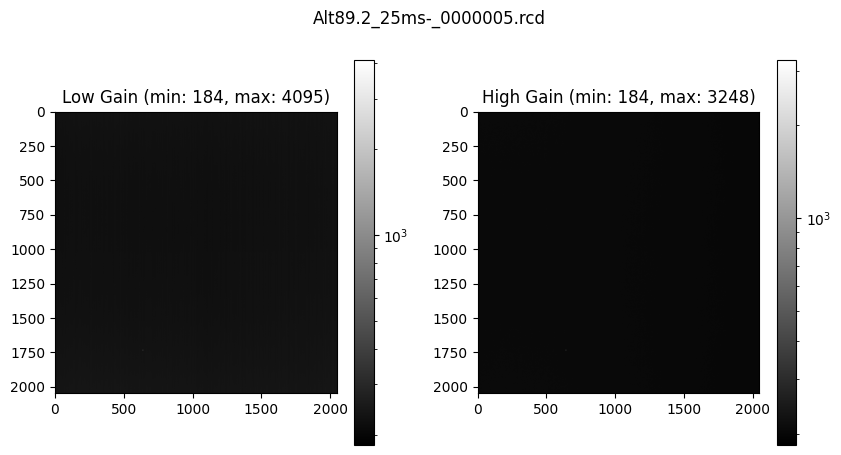

In [ ]:
# Function for reading specified number of bytes
def readxbytes(fid, numbytes):
    for i in range(1):
        data = fid.read(numbytes)
        if not data:
            break
    return data

# Function to read 12-bit data with Numba to speed things up
@nb.njit(nb.uint16[::1](nb.uint8[::1]),fastmath=True,parallel=True)
def nb_read_data(data_chunk):
    """data_chunk is a contigous 1D array of uint8 data)
    eg.data_chunk = np.frombuffer(data_chunk, dtype=np.uint8)"""
    #ensure that the data_chunk has the right length

    assert np.mod(data_chunk.shape[0],3)==0

    out=np.empty(data_chunk.shape[0]//3*2,dtype=np.uint16)
    image1 = np.empty((2048,2048),dtype=np.uint16)
    image2 = np.empty((2048,2048),dtype=np.uint16)

    for i in nb.prange(data_chunk.shape[0]//3):
        fst_uint8=np.uint16(data_chunk[i*3])
        mid_uint8=np.uint16(data_chunk[i*3+1])
        lst_uint8=np.uint16(data_chunk[i*3+2])

        out[i*2] =   (fst_uint8 << 4) + (mid_uint8 >> 4)
        out[i*2+1] = ((mid_uint8 % 16) << 8) + lst_uint8

    return out

def getSizeRCD(filenames):
    """ MJM - Get the size of the images and number of frames """
    filename_first = filenames[0]
    frames = len(filenames)

    width = 2048
    height = 2048

    # You could also get this from the RCD header by uncommenting the following code
    # with open(filename_first, 'rb') as fid:
    #     fid.seek(81,0)
    #     hpixels = readxbytes(fid, 2) # Number of horizontal pixels
    #     fid.seek(83,0)
    #     vpixels = readxbytes(fid, 2) # Number of vertical pixels

    #     fid.seek(100,0)
    #     binning = readxbytes(fid, 1)

    #     bins = int(binascii.hexlify(binning),16)
    #     hpix = int(binascii.hexlify(hpixels),16)
    #     vpix = int(binascii.hexlify(vpixels),16)
    #     width = int(hpix / bins)
    #     height = int(vpix / bins)

    return width, height, frames

# Function to split high and low gain images
def split_images(data,pix_h,pix_v,gain):
    interimg = np.reshape(data, [2*pix_v,pix_h])

    if gain == 'low':
        image = interimg[::2]
    else:
        image = interimg[1::2]

    return image
 
# Function to read RCD file data
def readRCD(filename):

    hdict = {}

    with open(filename, 'rb') as fid:

        # Go to start of file
        fid.seek(0,0)

        # Serial number of camera
        fid.seek(63,0)
        hdict['serialnum'] = readxbytes(fid, 9)

        # Timestamp
        fid.seek(152,0)
        hdict['timestamp'] = readxbytes(fid, 29).decode('utf-8')

        # Load data portion of file
        fid.seek(384,0)

        table = np.fromfile(fid, dtype=np.uint8, count=12582912)

    return table, hdict


hnumpix = 2048
vnumpix = 2048

data_dir = "/home/agirmen/Github/ColibriPipeline_SensitivityModel/Sensitivity_Test_Data/20240729/20240729_03.05.55.471"\

# Get the filepaths of all the files in the directory

filepaths = []
for root, dirs, files in os.walk(data_dir):
    files.sort()
    for file in files:
        if file.endswith(".rcd"):
            filepaths.append(os.path.join(root, file))


for file in filepaths[:5]:
    data, header = readRCD(file)
    print(header)
    images = nb_read_data(data)
    low_gain = split_images(images, hnumpix, vnumpix, 'low')
    high_gain = split_images(images, hnumpix, vnumpix, 'high')

    # Plot the low and high gain side by side with colorbars and log scale
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    cax0 = ax[0].imshow(low_gain, cmap='gray', norm=LogNorm(vmin=low_gain.min(), vmax=low_gain.max()))
    ax[0].set_title(f'Low Gain (min: {low_gain.min()}, max: {low_gain.max()})')
    fig.colorbar(cax0, ax=ax[0])
    # print the index of the maximum value in the low gain image

    cax1 = ax[1].imshow(high_gain, cmap='gray', norm=LogNorm(vmin=high_gain.min(), vmax=high_gain.max()))
    ax[1].set_title(f'High Gain (min: {high_gain.min()}, max: {high_gain.max()})')
    fig.colorbar(cax1, ax=ax[1])

    # Add title for frame number from the end of the filepath
    fig.suptitle(file.split('/')[-1])
    plt.show()



In [ ]:
from astropy.nddata import CCDData
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numba as nb


data_dir = "/home/agirmen/Github/ColibriPipeline_SensitivityModel/Sensitivity_Test_Data/20240729/20240729_03.05.55.471"\

# Get the filepaths of all the files in the directory

filepaths = []
for root, dirs, files in os.walk(data_dir):
    files.sort()
    for file in files:
        if file.endswith(".rcd"):
            filepaths.append(os.path.join(root, file))




def process_batch(filepaths):
    low_gain_batch = []
    high_gain_batch = []
    for file in filepaths:
        data, header = readRCD(file)
        images = nb_read_data(data)
        low_gain = split_images(images, hnumpix, vnumpix, 'low')
        high_gain = split_images(images, hnumpix, vnumpix, 'high')


        low_gain_batch.append(low_gain)
        high_gain_batch.append(high_gain)
        
    
    
    # Stack the batch
    stacked_low_gain_batch = np.median(np.array(low_gain_batch), axis=0)
    stacked_high_gain_batch = np.median(np.array(high_gain_batch), axis=0)
    
    return stacked_low_gain_batch, stacked_high_gain_batch


hnumpix = 2048
vnumpix = 2048
batch_size = 50  # Define the batch size

low_gain_images = []
high_gain_images = []

# Process images in batches
num_files = len(filepaths[:500])
for i in range(0, num_files, batch_size):
    batch_filepaths = filepaths[i:i + batch_size]
    stacked_low_gain_batch, stacked_high_gain_batch = process_batch(batch_filepaths)
    
    low_gain_images.append(stacked_low_gain_batch)
    high_gain_images.append(stacked_high_gain_batch)

# Combine the stacked results of each batch
final_stacked_low_gain = np.median(np.array(low_gain_images), axis=0)
final_stacked_high_gain = np.median(np.array(high_gain_images), axis=0)

# Plot the final stacked low and high gain images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cax0 = ax[0].imshow(final_stacked_low_gain, cmap='gray', norm=LogNorm(vmin=final_stacked_low_gain.min(), vmax=final_stacked_low_gain.max()))
ax[0].set_title(f'Stacked Low Gain (min: {final_stacked_low_gain.min()}, max: {final_stacked_low_gain.max()})')
# fig.colorbar(cax0, ax=ax[0])

cax1 = ax[1].imshow(final_stacked_high_gain, cmap='gray', norm=LogNorm(vmin=final_stacked_high_gain.min(), vmax=final_stacked_high_gain.max()))
ax[1].set_title(f'Stacked High Gain (min: {final_stacked_high_gain.min()}, max: {final_stacked_high_gain.max()})')
# fig.colorbar(cax1, ax=ax[1])

plt.show()

# Save the final stacked high gain image as a .fits file
hdu = fits.PrimaryHDU(final_stacked_high_gain)
hdul = fits.HDUList([hdu])

KeyboardInterrupt: 

In [ ]:
hdul.writeto('final_stacked_high_gain_median.fits', overwrite=False)

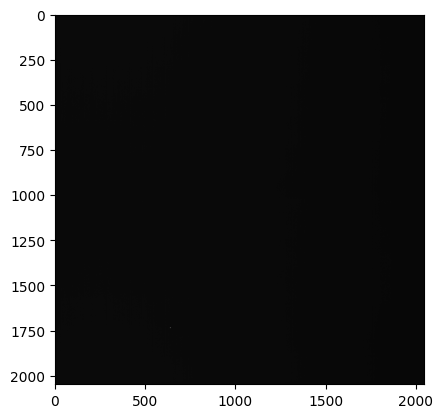

In [ ]:
# load the fits file
hdul = fits.open('./final_stacked_high_gain_100.fits')

# Get the data
data = hdul[0].data

# plot the data
plt.imshow(data, cmap='gray', norm=LogNorm(vmin=data.min(), vmax=data.max()))
plt.show()